# W2 - Geometry & Topoology

In this workshop we will learn about mesh data structures, how to import, visualize and export them in python. We will also learn about basic mesh manipulations.

## 0. Initialization

### 0.1. Importing libraries 

In [49]:
# basic libraries
import numpy as np

# computational geometry libraries
import meshplot as mp
from compas.datastructures import Mesh as CompasMesh
from compas_plotters.meshplotter import MeshPlotter

# libraries for connection to grasshopper (speckle)
from specklepy.api.client import SpeckleClient
from specklepy.api.credentials import get_default_account
from specklepy.transports.server import ServerTransport
from specklepy.api import operations
from specklepy.objects.geometry import Mesh as SpeckleMesh
from specklepy.objects.geometry import Base, Box, Interval, Vector, Point, Plane

### 0.2. Establish connection to speckle

In [3]:
# initialise the client
client = SpeckleClient(host="speckle.xyz", use_ssl=True)

# authenticate the client with a token
account = get_default_account()
client.authenticate(token=account.token)

# use that stream id to get the stream from the server
earthy_w2_stream = client.stream.get(id="5be382cdb7")

# creating a server transport 
transport = ServerTransport(client=client, stream_id=earthy_w2_stream.id)

## 1. Mesh In

### 1.1. Importing OBJ files

In [3]:
base_grid_filepath = "../data/base_grid.obj"
base_grid_mesh = CompasMesh.from_obj(base_grid_filepath)

/Users/shervinazadi/opt/miniconda3/envs/earthy/lib/python3.8/site-packages/compas_plotters/plotter.py:243: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  self.figure.canvas.set_window_title(value)


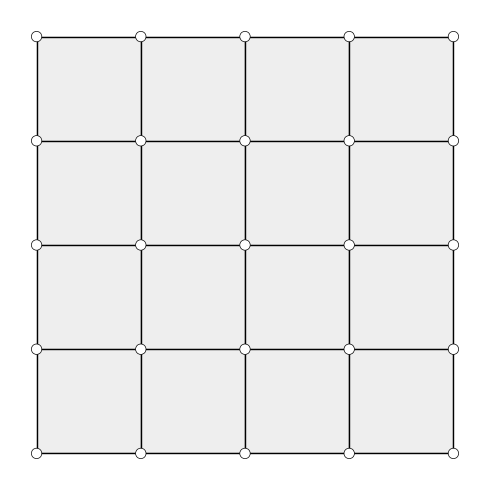

In [4]:
# plot the mesh
plotter = MeshPlotter(base_grid_mesh, figsize=(5, 5))
plotter.draw_edges()
plotter.draw_vertices(radius=.05)
plotter.draw_faces()
plotter.show()

### 1.2. Importing from Grasshopper (Speckle)

In [80]:
# find base box reference id
last_geo_ref = client.commit.list(earthy_test_stream.id)[0].referencedObject

# this receives the object back from the transport.
received_mesh = operations.receive(obj_id=last_geo_ref, remote_transport=transport)

In [81]:
# unwrap the mesh data
received_mesh_dict = received_mesh.dict()["@data"][0][0]
received_mesh_V = np.array(received_mesh_dict["vertices"]).reshape((-1, 3))
received_mesh_F = np.array(received_mesh_dict["faces"]).reshape((-1, 4))[:, 1:]

In [82]:
mp.plot(received_mesh_V, received_mesh_F)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.000104…

## 2. Mesh Manipulation & Analysis

### 2.1. Mesh Data Structure 

In [84]:
# construct the compas mesh
received_mesh_compas = CompasMesh.from_vertices_and_faces(received_mesh_V,received_mesh_F)

(V, F) = received_mesh_compas.to_vertices_and_faces()
# print("Vertices: ", V)
# print("Faces: ", F)

In [85]:
# advanced visualization
E = np.array(list(received_mesh_compas.edges()))
p = mp.plot(received_mesh_V, received_mesh_F, return_plot=True)
p.add_edges(received_mesh_V, E, shading={"line_color": "black"})
p.add_points(received_mesh_V, shading={"point_size": 0.2})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.000104…

2

### 2.2. Basic Mesh Transformation

In [86]:
edited_V = received_mesh_V * np.array([1,1.5,1])
mp.plot(edited_V, received_mesh_F)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.000104…

### 2.3. Dual

In [38]:
# construct the compas mesh
edited_mesh_compas = CompasMesh.from_vertices_and_faces(edited_V,received_mesh_F)

## 3. Mesh Out

### 3.1. Saving OBJ files

In [39]:
edited_mesh_compas.to_obj("../data/edited_mesh.obj")

### 3.2. Exporting to Grasshopper (Speckle)

In [87]:
def convert_mesh_compas_to_speckle(compas_mesh):
    (V, F) = compas_mesh.to_vertices_and_faces()
    (V_arr, F_arr) = (np.array(V), np.array(F))
    F_arr = np.pad(F_arr, ((0,0),(1,0)), mode='constant', constant_values=0)

    base_plane = Plane(
        origin=Point(x=0, y=0, z=0), 
        xdir= Vector(x=1, y=0, z=0), 
        ydir= Vector(x=0, y=1, z=0),
        normal= Vector(x=0, y=0, z=1))
    
    bounding_box = Box(
        basePlane = base_plane,
        area = 1,
        volume = 1,
        xSize = Interval(start=V_arr[:,0].min(), end=V_arr[:,0].max()), 
        ySize = Interval(start=V_arr[:,1].min(), end=V_arr[:,1].max()), 
        zSize = Interval(start=V_arr[:,2].min(), end=V_arr[:,2].max()))

    speckle_mesh = SpeckleMesh(
        vertices = V_arr.flatten().tolist(), 
        faces = F_arr.flatten().tolist(),
        # colors = [],
        # area = 0,
        # volume = 1,
        # bbox = bounding_box
        )

    speckle_wrapped_mesh = Base(
        data = [[speckle_mesh]]
    )
    return speckle_mesh

# construct speckle mesh
edited_mesh_speckle = convert_mesh_compas_to_speckle(edited_mesh_compas)

In [88]:

# Serialises the block and sends it to the transport
edited_mesh_hash = operations.send(base=edited_mesh_speckle, transports=[transport])

# TODO
# creating a commit on your stream with this object
commid_id = client.commit.create(
    stream_id=earthy_w2_stream.id, 
    object_id=edited_mesh_hash, 
    message="edited_mesh",
    )

## Credits

In [ ]:
__author__ = "Shervin Azadi"
__license__ = "MIT"
__version__ = "1.0"
__url__ = "https://github.com/shervinazadi/earthy_workshops"
__summary__ = "Earthy Design Studio Workshop on Geometry and Topology"